Introduction

In today's dynamic insurance landscape, accurate premium estimation is crucial for both insurers and policyholders. Our project leverages data analysis, geospatial insights, and machine learning to develop a predictive model that tailors insurance premiums to individual vehicles. By considering factors such as vehicle characteristics, driving behavior, and geographic influences, we empower insurers to make informed pricing decisions while ensuring policyholders receive customized and fair insurance rates. Join us on a journey to enhance the precision of insurance premium calculations, improving risk assessment and customer satisfaction.

Problem Statement

Develop a data analysis and modeling pipeline for an insurance company to estimate insurance premiums for vehicles based on their characteristics and driving behavior. The goal is to build a predictive model that can accurately calculate the insurance premium for a given vehicle, taking into account factors such as the vehicle type, speed, and location.

Key Components of Solving this Problem

1. Data Ingestion. The problem involves reading data from an external source, a report file ('1MData.rpt' in this case), and converting it into a usable format (i.e. a Pandas DataFrame).

2. Data Preprocessing. The code performs various data preprocessing tasks, such as splitting date and time from a timestamp, calculating total distances driven by each vehicle, and computing average speeds. These preprocessing steps are essential for feature engineering and model building.

3. Geospatial Analysis. The code uses GeoPandas to work with geospatial data and potentially includes the geographical location('geometry')as a factor in premium estimation.

4. Feature Selection. The code selects specific features ('vehicle', 'speed', 'geometry', etc.) to be used for premium prediction.

5. Machine Learning Modeling. The code uses a machine learning regression model (Linear Regression) to build a predictive model. It splits the data into training and testing sets, fits the model to the training data, and evaluates its performance using Mean Squared Error (MSE). The model aims to predict the 'premium' variable based on the selected features.

6. Business Context. The problem is situated in the context of an insurance company looking to price insurance premiums for vehicles accurately. The 'premium' variable represents the financial amount the company would charge customers for coverage.

7. Customization. The model should be flexible enough to provide customized premium estimates for individual vehicles based on their specific attributes and driving behavior.

8. Performance Evaluation. The code calculates and reports the performance of the predictive model using the MSE metric, which quantifies the accuracy of premium predictions.

The goals of the project encompass building an accurate premium prediction model, leveraging data analysis and geospatial analysis to inform pricing decisions, and providing customized insurance premium estimates while adhering to industry standards and compliance. The project aims to enhance the insurance company's ability to set competitive and actuarially sound premium rates. 


In [290]:
#Here it is necessary to import necessary libraries and modules
import geopandas as gp
import pandas as pd
import fiona
import pyogrio
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

This line sets the variable myfile to the string "1MData.rpt", which appears to be a filename or path.

In [274]:
#myfile is defined as the filename '1MData.rpt'.
myfile='1MData.rpt'

In [275]:
#The read_rpt function is defined here. It reads the content of a text file specified by the myfile parameter. 
#The read_rpt function is defined to read the content of a text file specified by the myfile parameter and create a 
#Pandas DataFrame from it. 
def read_rpt(myfile):
    #Function that helps import rpt file and create pandas dataframe
    count = 1#Initializes a variable count to 1. 
    #This variable will be used to keep track of the line number being read from the file.
    colspecs = []#Initializes an empty list called colspecs. This list will be used to store the 
    #column specifications for reading the data from the file.
    idx = 0 #Initializes an index variable idx to 0. This variable will be used to keep 
    #track of the starting position of each column in the file.
    for x in open(myfile, encoding='utf8'): #Opens the file specified by the myfile parameter for reading, with UTF-8 encoding. 
        #It then enters a loop to iterate through each line in the file.
        cols = x.rstrip()  # remove newline character--Reads a line from the file, removes any trailing newline character 
        #('\n') using the rstrip() method, and stores the cleaned line in the cols variable.
        count += 1#Increments the count variable to keep track of the line number being processed.
        if count > 2:#Checks if the line number is greater than 2. If it is, it means that the first two lines(header or metadata) have already been read, and it breaks out of 
            #the loop. This is because the code assumes that the column specifications can be determined after 
            #the first two lines.
            break
    # build colspecs list that specifies the starting and end positions of each column in the file.
    for c in cols.split(' '):
        n = len(c)
        colspecs.append((idx, idx + n))
        idx += 1 + n
    return pd.read_fwf(myfile, colspecs=colspecs, encoding='utf8', skiprows=[1])

The goe_df function takes a Pandas DataFrame as an input and converts it into a Shapely geometries (Points).  It also drops the 'longitude' and 'latitude' columns from the DataFrame and creates a GeoDataFrame using GeoPandas with the specified CRS(Coordinate Reference System). The function returns the GeoDataFrame called gdf.


In [276]:
def geo_df(pandas_df):
    #goe_df function takes a Pandas DataFrame as an input and converts it into a Shapely geometries (Points)
    #Convert the DataFrame's content into Shapely geometries
    geometry = [Point(xy) for xy in zip(pandas_df.longitude, pandas_df.latitude)]
    udf = pandas_df.drop(['longitude', 'latitude'], axis=1)
    gdf = gp.GeoDataFrame(udf, crs="EPSG:4326", geometry=geometry)
    return gdf

Here the premium Function calculates premium amounts based on distance and speed.
It defines rules for calculating premiums based on the values of distance and speed.
The calculated premiums are returned as a list.

Distance Premium Calculation:

The function iterates through the distance list using a for loop.
For each distance value i, it checks different conditions to determine the premium for that distance.
If the distance is less than 16,094 meters, a premium of 50 is assigned.
If the distance is between 16,904 and 24,141 meters, a premium of 80 is assigned.
If the distance is between 24,141 and 48,282 meters (twice 24,141), a premium of 120 is assigned.
If the distance is between 48,282 and 96,564 meters (twice 48,282), a premium of 160 is assigned.
If the distance is between 96,564 and 193,128 meters (twice 96,564), a premium of 205 is assigned.
If none of the conditions are met, a default premium of 300 is assigned.
The calculated premium for each distance value is appended to the distance_calc list.

Speed Premium Calculation:

The function iterates through the speed list using a for loop.
For each speed value j, it checks different conditions to determine the premium for that speed.
If the speed is less than 41 km/h, a premium of 15 is assigned.
If the speed is between 41 km/h and 105 km/h, a premium of 25 is assigned.
If the speed is between 105 km/h and 129 km/h, a premium of 35 is assigned.
If none of the conditions are met, a default premium of 50 is assigned.
The calculated premium for each speed value is appended to the speed_calc list.


In [277]:
def premium(distance, speed):
    #Calculate Premium based on distance and speed
    base_rate = 30
    #These two empty lists will be used to store intermediate premium calculations for distance and speed.
    distance_calc = []
    speed_calc = []
    for i in distance:
        if i < 16094:
            distance_calc.append(50)
        elif (i > 16904) & (i < 24141):
            distance_calc.append(80)
        elif (i > 24141) & (i < 24141*2):
            distance_calc.append(120)
        elif (i > 24141*2) & (i < 24141*2*2):
            distance_calc.append(160)
        elif (i > 24141*2*2) & (i < 24141*2*2*2):
            distance_calc.append(205)
        else:
            distance_calc.append(300)
    for j in speed:
        if j < 41:
            speed_calc.append(15)
        elif (j > 41) & (j < 105):
            speed_calc.append(25)
        elif (j > 105) & (j < 129):
            speed_calc.append(35)
        else:
            speed_calc.append(50)
    #This line calculates the total risk for each data point by adding the corresponding values 
    #from the distance_calc and speed_calc lists.        
    risk = [distance_calc[i] + speed_calc[i] for i in range(len(distance_calc))]
    #This line calculates the final premium for each data point by adding the base rate (30) to the corresponding 
    #risk value from the risk list.
    premium = [i + base_rate for i in risk]
    #The function returns a list of premium values corresponding to the input distance and speed data points.
    return premium

In summary, the premium function takes distance and speed data as input, applies specific rules to calculate individual premiums for each data point, and returns a list of premium values based on those rules. The final premium is a combination of distance-based and speed-based premiums with a fixed base rate

Here the data is read in from myfile ('1MData.rpt' file) using the read_rpt function and assigns it to the DataFrame df.  The first 10 rows of the DataFrame are printed.

In [278]:
df = read_rpt(myfile)
print(df.head(10))

  vehicle                  utcDate  longitude  latitude  altitude  angle   
0   13510  2019-06-13 14:12:52.000    25.2888   35.1171     262.0  323.0  \
1   13510  2019-06-13 14:12:28.000    25.2905   35.1116     246.0  353.0   
2   13510  2019-06-13 14:11:35.000    25.2952   35.0993     217.0  318.0   
3   13510  2019-06-13 14:11:10.000    25.3010   35.0949     238.0  326.0   
4   13510  2019-06-13 14:10:47.000    25.3060   35.0900     268.0  315.0   
5   13510  2019-06-13 14:09:53.000    25.3170   35.0808     272.0  297.0   
6   13510  2019-06-13 14:15:11.000    25.2724   35.1353     397.0  275.0   
7   13510  2019-06-13 14:13:20.000    25.2843   35.1222     289.0  351.0   
8   13510  2019-06-13 14:10:23.000    25.3117   35.0855     285.0  316.0   
9   13510  2019-06-13 14:18:35.000    25.2564   35.1478     348.0  324.0   

   speed  odometer  satellites  
0   94.0     638.0        17.0  
1   97.0     725.0        17.0  
2   97.0     729.0        17.0  
3  109.0     710.0        16.0 

Below we create a GeoDataFrame.  The code converts the Pandas DataFrame df into a GeoDataFrame gf using the geo_df function.

The "Vehicle" column a random keys generated for vehicles
The "utcDate" column is coordinated with the universal time of the vehicle on the GPS date
The "altitude" column is the GPS altitude
The "angle" column is based on two consecutive GPS coordinates
The "speed" column is the speed of the vehicle based on the GPS
The "odometer" column is the distance in meters between 2 successive GPS coordinates
The "satellites" column is the number of satellites seen by the GPS Antenna
The "geometry" column is the objective for the geopandas module. Maps out the vehichle's route by using coordinates

In [279]:
gf = geo_df(df)
gf.head(10)

,vehicle,utcDate,altitude,angle,speed,odometer,satellites,geometry
0,13510,2019-06-13 14:12:52.000,262.0,323.0,94.0,638.0,17.0,POINT (25.28880 35.11710)
1,13510,2019-06-13 14:12:28.000,246.0,353.0,97.0,725.0,17.0,POINT (25.29050 35.11160)
2,13510,2019-06-13 14:11:35.000,217.0,318.0,97.0,729.0,17.0,POINT (25.29520 35.09930)
3,13510,2019-06-13 14:11:10.000,238.0,326.0,109.0,710.0,16.0,POINT (25.30100 35.09490)
4,13510,2019-06-13 14:10:47.000,268.0,315.0,116.0,721.0,17.0,POINT (25.30600 35.09000)
5,13510,2019-06-13 14:09:53.000,272.0,297.0,87.0,545.0,17.0,POINT (25.31700 35.08080)
6,13510,2019-06-13 14:15:11.000,397.0,275.0,61.0,576.0,17.0,POINT (25.27240 35.13530)
7,13510,2019-06-13 14:13:20.000,289.0,351.0,81.0,721.0,17.0,POINT (25.28430 35.12220)
8,13510,2019-06-13 14:10:23.000,285.0,316.0,97.0,718.0,17.0,POINT (25.31170 35.08550)
9,13510,2019-06-13 14:18:35.000,348.0,324.0,37.0,70.0,17.0,POINT (25.25640 35.14780)


For basic statstistics, here the code calculates basic statistics from the data, such as the maximum and minimum speed, longest and shortest trip distances, and prints these statistics.

To get basic summary statistics for a Pandas DataFrame, here we use the describe() method, which provides various statistics for each numerical column in the DataFrame. This gives us statistics like count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile), 75th percentile (Q3), and maximum for all numerical columns in your DataFrame df.

In [280]:
summary_statistics = df.describe()
print(summary_statistics)


            longitude        latitude        altitude           angle   
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000  \
mean        23.141219       38.852909      106.866517      181.467545   
std          1.360154        1.680652      158.769074      103.221469   
min         19.682400       34.930600        0.000000        0.000000   
25%         22.491100       37.960400       16.000000       92.000000   
50%         23.005700       38.232600       47.000000      181.000000   
75%         23.715000       39.601700      118.000000      272.000000   
max         28.653300       45.695500     1274.000000      360.000000   

                speed      odometer      satellites  
count  1000000.000000  1.000000e+06  1000000.000000  
mean        42.997446  2.487190e+04       14.413993  
std         35.955315  1.549606e+06        2.959892  
min          0.000000  0.000000e+00        4.000000  
25%         12.000000  1.600000e+01       13.000000  
50%         32.000

In [281]:
# Include all columns, including non-numeric ones
summary_statistics = df.describe(include='all')  
print(summary_statistics)


        vehicle                  utcDate       longitude        latitude   
count   1000001                  1000000  1000000.000000  1000000.000000  \
unique       45                   944677             NaN             NaN   
top       13865  2020-02-06 12:39:40.000             NaN             NaN   
freq      82989                        5             NaN             NaN   
mean        NaN                      NaN       23.141219       38.852909   
std         NaN                      NaN        1.360154        1.680652   
min         NaN                      NaN       19.682400       34.930600   
25%         NaN                      NaN       22.491100       37.960400   
50%         NaN                      NaN       23.005700       38.232600   
75%         NaN                      NaN       23.715000       39.601700   
max         NaN                      NaN       28.653300       45.695500   

              altitude           angle           speed      odometer   
count   1000000

This code generates a summary of basic statistics related to trip distances and speeds in the dataset and prints this summary to the console for the user to see.

In [282]:
#Basic Stats from the data sets
#calculates the maximum speed(km/h)fromthe'speed'column ofthe DataFrame df and assigns it to the variable max_speed 
max_speed = df.speed.max()
#calculates the minimum speed(km/h)from the 'speed' column of the DataFrame df and assigns it to the 
#variable min_speed.
min_speed = df.speed.min()
#longest_trip calculates the longest trip distance(meters) rom the'odometer'column of the DataFrame df 
#and assigns it to the variable longest_trip.
longest_trip = df.odometer.max()
#shortest_trip calculates the shortest trip distance (meters) from the 'odometer' column of 
#the DataFrame df and assigns it to the variable shortest_trip.
shortest_trip = df.odometer.min()
#summary creates a string variable summary that includes the shortest and longest 
#trip distances from longest_trip and shortest_trip. It uses string formatting to insert these values into the text.
summary = 'Based on the dataset, the shortest trip reported was {0} meters, while the longest trip was {1} meters.'.format(shortest_trip, longest_trip)
#summary_2 creates another string variable summary_2 that includes the slowest and fastest speed values. 
#It also uses string formatting to insert these values into the text.
summary_2 = 'The slowest speed recorded was {0} km/h and the fastest speed was {1} km/h'.format(min_speed, max_speed)
#The printed output will provide a summary of the shortest and longest trip distances, as well as the 
#slowest and fastest recorded speeds in the dataset.
print(summary, summary_2)

Based on the dataset, the shortest trip reported was 0.0 meters, while the longest trip was 97678100.0 meters. The slowest speed recorded was 0.0 km/h and the fastest speed was 199.0 km/h


In [283]:
#Split utcDate to two columns for date and time
dates = pd.to_datetime(df['utcDate']).dt.date
times = pd.to_datetime(df['utcDate']).dt.time

df.insert(1, 'dates', dates)
df.insert(2, 'times', times)
df.pop('utcDate')
df.head(10)

,vehicle,dates,times,longitude,latitude,altitude,angle,speed,odometer,satellites
0,13510,2019-06-13,14:12:52,25.2888,35.1171,262.0,323.0,94.0,638.0,17.0
1,13510,2019-06-13,14:12:28,25.2905,35.1116,246.0,353.0,97.0,725.0,17.0
2,13510,2019-06-13,14:11:35,25.2952,35.0993,217.0,318.0,97.0,729.0,17.0
3,13510,2019-06-13,14:11:10,25.3010,35.0949,238.0,326.0,109.0,710.0,16.0
4,13510,2019-06-13,14:10:47,25.3060,35.0900,268.0,315.0,116.0,721.0,17.0
5,13510,2019-06-13,14:09:53,25.3170,35.0808,272.0,297.0,87.0,545.0,17.0
6,13510,2019-06-13,14:15:11,25.2724,35.1353,397.0,275.0,61.0,576.0,17.0
7,13510,2019-06-13,14:13:20,25.2843,35.1222,289.0,351.0,81.0,721.0,17.0
8,13510,2019-06-13,14:10:23,25.3117,35.0855,285.0,316.0,97.0,718.0,17.0
9,13510,2019-06-13,14:18:35,25.2564,35.1478,348.0,324.0,37.0,70.0,17.0


In [284]:
#Calculating total distance driven for each vehicle
m_driven = df.groupby('vehicle').odometer.sum().reset_index()
m_driven.drop(index=m_driven.index[0], axis=0, inplace=True)
m_driven.rename(columns={
    'vehicle': 'vehicle_id',
    'odometer': 'total_distance_meters'
},inplace=True
)

print(m_driven)

   vehicle_id  total_distance_meters
1       10187           4.952135e+06
2       10188           1.343464e+07
3       11860           9.466385e+06
4       11861           4.442444e+06
5       11862           5.570483e+06
6       11863           4.269032e+06
7       11865           7.136055e+06
8       11867           1.293179e+07
9       11868           3.103135e+06
10      11869           2.944187e+06
11      11870           1.750096e+07
12      11871           9.719940e+06
13      11872           1.197146e+07
14      13510           3.627053e+06
15      13865           1.924176e+07
16      13866           1.544298e+06
17      13867           1.245810e+07
18      13975           1.070917e+06
19      13976           1.435464e+07
20      13977           1.457234e+07
21       1682           6.499100e+04
22      17070           1.434254e+07
23      17071           1.410870e+07
24      17072           1.127532e+07
25      17073           8.208074e+06
26      17074           1.397347e+07
2

In [285]:
#Converting meters to Km and adding corresponding column in dataframe

m_driven['total_distance_kilometers'] = [i/1000 for i in m_driven['total_distance_meters']]
m_driven.head(10)

,vehicle_id,total_distance_meters,total_distance_kilometers
1,10187,4952135.0,4952.135
2,10188,13434641.0,13434.641
3,11860,9466385.0,9466.385
4,11861,4442444.0,4442.444
5,11862,5570483.0,5570.483
6,11863,4269032.0,4269.032
7,11865,7136055.0,7136.055
8,11867,12931789.0,12931.789
9,11868,3103135.0,3103.135
10,11869,2944187.0,2944.187


In [286]:
#Sorting total_distance by vehicles that drive the most
#m_driven_sorted = m_driven.sort_values(by='total_distance_meters', ascending=False)
avg_speed = df.groupby('vehicle').speed.mean().reset_index()
avg_speed.drop(index=avg_speed.index[0], axis=0, inplace=True)
m_driven_and_avg_speed = m_driven
m_driven_and_avg_speed['average_speed'] = avg_speed['speed']
m_driven_and_avg_speed.head(10)
#avg_speed.head(10)

,vehicle_id,total_distance_meters,total_distance_kilometers,average_speed
1,10187,4952135.0,4952.135,37.351043
2,10188,13434641.0,13434.641,71.496871
3,11860,9466385.0,9466.385,53.484559
4,11861,4442444.0,4442.444,20.594524
5,11862,5570483.0,5570.483,33.309401
6,11863,4269032.0,4269.032,21.594573
7,11865,7136055.0,7136.055,32.283347
8,11867,12931789.0,12931.789,54.998588
9,11868,3103135.0,3103.135,24.088372
10,11869,2944187.0,2944.187,50.744741


In [287]:
#Vehicle with the highest average speed
print(m_driven_and_avg_speed.loc[m_driven_and_avg_speed['average_speed'].idxmax()])

vehicle_id                        10188
total_distance_meters        13434641.0
total_distance_kilometers     13434.641
average_speed                 71.496871
Name: 2, dtype: object


In [288]:
#Vehicle with the highest distance traveled
print(m_driven_and_avg_speed.loc[m_driven_and_avg_speed['total_distance_meters'].idxmax()])

vehicle_id                            9705
total_distance_meters        24602390100.0
total_distance_kilometers       24602390.1
average_speed                    26.142857
Name: 44, dtype: object


In [289]:
#Use the Geopandas module to plot the geometries
#Create the model to price premium

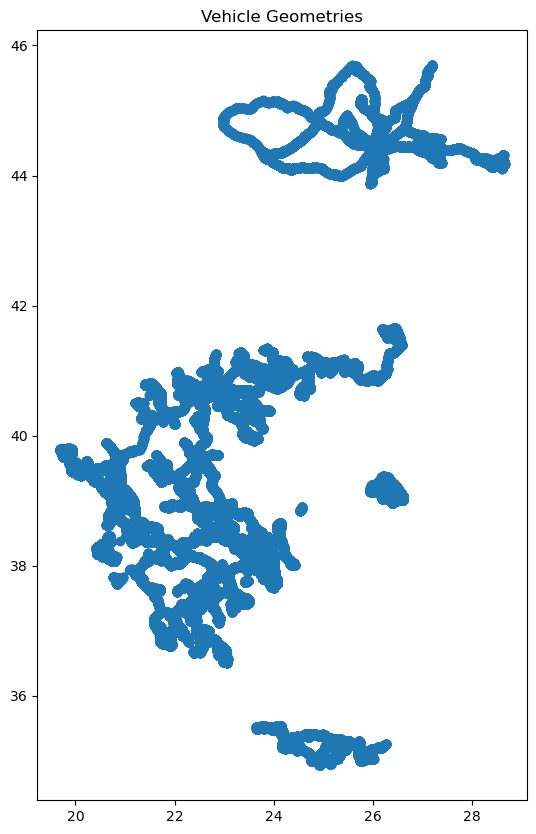

In [233]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you already have the 'gf' GeoDataFrame
gf.plot(figsize=(10, 10))
plt.title('Vehicle Geometries')
plt.show()

In [234]:
m_driven_and_avg_speed['monthly_premium'] = premium(m_driven_and_avg_speed['total_distance_kilometers'], m_driven_and_avg_speed['average_speed'])
m_driven_and_avg_speed.head(10)

,vehicle_id,total_distance_meters,total_distance_kilometers,average_speed,monthly_premium
1,10187,4952135.0,4952.135,37.351043,95
2,10188,13434641.0,13434.641,71.496871,105
3,11860,9466385.0,9466.385,53.484559,105
4,11861,4442444.0,4442.444,20.594524,95
5,11862,5570483.0,5570.483,33.309401,95
6,11863,4269032.0,4269.032,21.594573,95
7,11865,7136055.0,7136.055,32.283347,95
8,11867,12931789.0,12931.789,54.998588,105
9,11868,3103135.0,3103.135,24.088372,95
10,11869,2944187.0,2944.187,50.744741,105


In [235]:
m_driven_and_avg_speed['6_month_premium'] = [i * 6 for i in m_driven_and_avg_speed['monthly_premium']]
m_driven_and_avg_speed.head(10)

,vehicle_id,total_distance_meters,total_distance_kilometers,average_speed,monthly_premium,6_month_premium
1,10187,4952135.0,4952.135,37.351043,95,570
2,10188,13434641.0,13434.641,71.496871,105,630
3,11860,9466385.0,9466.385,53.484559,105,630
4,11861,4442444.0,4442.444,20.594524,95,570
5,11862,5570483.0,5570.483,33.309401,95,570
6,11863,4269032.0,4269.032,21.594573,95,570
7,11865,7136055.0,7136.055,32.283347,95,570
8,11867,12931789.0,12931.789,54.998588,105,630
9,11868,3103135.0,3103.135,24.088372,95,570
10,11869,2944187.0,2944.187,50.744741,105,630


To create a model to price premium, we need to create a model that prices the premium. We will use the target variable and select the features that will be used to help predict the premium value.  Do do this we use scikit-learn to build the regresson model as seen in the code below and we need to do a few things:
1. Create and train a linear regression model.
2. Make predictions.
3. Evaluate the Model.
4. Use the trained model to predict premium for new data points

Model 1:

In [236]:
# Assuming you have selected the features and target variable
features = ['total_distance_kilometers', 'average_speed']  # Adjust features as needed
target = 'monthly_premium'  # Choose the target variable you want to predict

In [237]:
# Split the data into training and testing sets
X = m_driven_and_avg_speed[features]
y = m_driven_and_avg_speed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [239]:
# Make predictions
y_pred = model.predict(X_test)

Mean Squared Error (MSE) measures the average squared difference between the predicted and actual values. Lower MSE indicates a better model fit.

In [240]:
# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 6.126633952460653


An R-squared (R²) score of 0.7243014721392707, which is approximately 0.72, indicates the proportion of the variance in the dependent variable (the target variable) that can be explained by the independent variables (features) in the regression model. Additionally, the following can be said: 

1. When looking at Goodness of Fit, R-squared value is between 0 and 1, where higher values are better. In this case, an R-squared value of approximately 0.72 suggests that the model explains approximately 72.43% of the variance in the target variable. 

2. When looking at Model Accuracy, a higher R-squared value suggests that the model provides a good fit to the data. It means that the features included in the model collectively have a strong explanatory power regarding the variation in the target variable.

In summary, an R-squared value of approximately 0.72 indicates a model that explains a substantial portion of the variance in the target variable, suggesting a good fit to the data. However, as with any statistical metric, its interpretation should be considered in the context of the specific problem and domain.








In [241]:

r_squared = r2_score(y_test, y_pred)
print(f'R-squared (R²) Score: {r_squared}')


R-squared (R²) Score: 0.7243014721392707


Below we look at adjusted R-Squared. Adjusted R-squared is a modified version of R-squared that takes into account the number of predictors in the model. It penalizes the inclusion of irrelevant features.



In [242]:
from sklearn.metrics import r2_score

# Assuming you have already calculated 'y_test' and 'y_pred'
r_squared = r2_score(y_test, y_pred)

# Calculate adjusted R-squared
n = len(y_test)  # Number of samples
p = len(features)  # Number of features
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
print(f'Adjusted R-squared: {adjusted_r_squared}')

Adjusted R-squared: 0.6324019628523609


An adjusted R-squared value of 0.6324019628523609 indicates the proportion of the variance in the dependent variable (the target variable) that can be explained by the independent variables (features) in the regression model, after adjusting for the number of predictors in the model. When it comes to goodness of fit, model complexity, model utility, comparisons, and residual analysis, the following analysis can be applied. 

Goodness of Fit: The adjusted R-squared value is between 0 and 1, where higher values are better. 0.6324 suggests that the model explains approximately 63.24% of the variance in the target variable. This indicates a moderate level of explanation, which is generally considered acceptable for many practical purposes.

Model Complexity: The adjusted R-squared value takes into account the number of predictors (features) in the model. A higher number of predictors tends to increase the regular R-squared value, but it may not necessarily lead to a better model. The adjusted R-squared penalizes the inclusion of irrelevant or redundant features, providing a more realistic assessment of model fit.

Model Utility: The interpretation of the adjusted R-squared value depends on the context and the specific problem that is being addressed. Whether a value of 0.6324 is good or not depends on the domain and the expectations of your application. In some cases, this level of explanation might be considered excellent, while in others, it might be deemed insufficient.

Comparisons: To assess the quality of the model further, we can compare the adjusted R-squared value with other models or variations of your model. A higher adjusted R-squared value suggests a better model fit, but it should be balanced with model simplicity and interpretability.

Residual Analysis: While the adjusted R-squared provides valuable information, it's essential to complement this evaluation with other diagnostic tools, such as residual analysis, to ensure the model's assumptions are met and that there are no systematic patterns or issues with the model's predictions.


In [269]:
# Here the trained model is used to predict premium for new data points
new_data = pd.DataFrame({'total_distance_kilometers': [1000], 'average_speed': [80]})
predicted_monthly_premium = model.predict(new_data)
print(f'Predicted Monthly Premium: {predicted_monthly_premium[0]}')


Predicted Monthly Premium: 116.09195336904374


In [252]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate RMSE for Linear Regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print RMSE for both models
print(f'Linear Regression RMSE: {rmse}')



Linear Regression RMSE: 2.475203820387455


Model 2:

In [253]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Here is model 2. The code below creates and trains the decision Tree Regressor model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)




DecisionTreeRegressor(random_state=42)

In [254]:
# Make predictions
y_pred_tree = decision_tree_model.predict(X_test)



In [255]:
# Evaluate the model
r_squared_tree = r2_score(y_test, y_pred_tree)
adjusted_r_squared_tree = 1 - ((1 - r_squared_tree) * (len(y_test) - 1) / (len(y_test) - len(features) - 1))
rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)
mae_tree = mean_absolute_error(y_test, y_pred_tree)


In [257]:
import numpy as np
from sklearn.metrics import mean_squared_error


# Calculate RMSE for Linear Regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate RMSE for Decision Tree Regressor
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

# Print RMSE for both models
print(f'Linear Regression RMSE: {rmse}')
print(f'Decision Tree Regressor RMSE: {rmse_tree}')


Linear Regression RMSE: 2.475203820387455
Decision Tree Regressor RMSE: 0.0


In [260]:
from sklearn.metrics import mean_absolute_error
# Calculate MAE for Linear Regression
mae = mean_absolute_error(y_test, y_pred)

# Calculate MAE for Decision Tree Regressor
mae_tree = mean_absolute_error(y_test, y_pred_tree)

# Print MAE for both models
print(f'Linear Regression MAE: {mae}')
print(f'Decision Tree Regressor MAE: {mae_tree}')


Linear Regression MAE: 1.8257913902102212
Decision Tree Regressor MAE: 0.0


In [261]:

print(f'R-squared (Decision Tree): {r_squared_tree}')
print(f'Adjusted R-squared (Decision Tree): {adjusted_r_squared_tree}')
print(f'RMSE (Decision Tree): {rmse_tree}')
print(f'MAE (Decision Tree): {mae_tree}')

R-squared (Decision Tree): 1.0
Adjusted R-squared (Decision Tree): 1.0
RMSE (Decision Tree): 0.0
MAE (Decision Tree): 0.0


Create a predictive model.

In [271]:
# Create a DataFrame with new data points for prediction
new_data = pd.DataFrame({'total_distance_kilometers': [1000], 'average_speed': [80]})

# Use the trained Decision Tree model to predict premium for new data points
predicted_premium_tree = decision_tree_model.predict(new_data)

# Print the predicted premium
print(f'Predicted Premium (Decision Tree Regressor): {predicted_premium_tree[0]}')


Predicted Premium (Decision Tree Regressor): 105.0


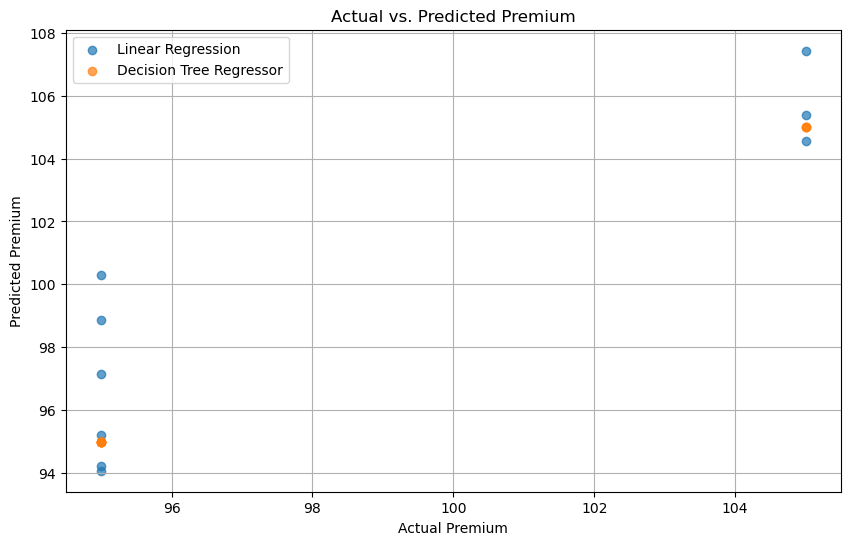

Linear Regression R-squared: 0.7243014721392707
Decision Tree Regressor R-squared: 1.0
Linear Regression Adjusted R-squared: 0.6324019628523609
Decision Tree Regressor Adjusted R-squared: 1.0
Linear Regression RMSE: 2.475203820387455
Decision Tree Regressor RMSE: 0.0
Linear Regression MAE: 1.8257913902102212
Decision Tree Regressor MAE: 0.0


In [272]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have both Linear Regression and Decision Tree models trained and predictions made

# Plot the actual vs. predicted values for both models
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label='Linear Regression', alpha=0.7)
plt.scatter(y_test, y_pred_tree, label='Decision Tree Regressor', alpha=0.7)
plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')
plt.title('Actual vs. Predicted Premium')
plt.legend()
plt.grid(True)
plt.show()

# Compare evaluation metrics
print(f'Linear Regression R-squared: {r_squared}')
print(f'Decision Tree Regressor R-squared: {r_squared_tree}')

print(f'Linear Regression Adjusted R-squared: {adjusted_r_squared}')
print(f'Decision Tree Regressor Adjusted R-squared: {adjusted_r_squared_tree}')

print(f'Linear Regression RMSE: {rmse}')
print(f'Decision Tree Regressor RMSE: {rmse_tree}')

print(f'Linear Regression MAE: {mae}')
print(f'Decision Tree Regressor MAE: {mae_tree}')


Results

The scatter plot reveals the following about the two models:

1. The Linear Regression model shows a positive correlation and reasonably accurate predictions, with some outliers.

2. The Decision Tree Regressor model appears to have overfitted the data, resulting in perfect predictions on the test data. However, this level of perfect alignment with the actual values may be suspicious and could indicate overfitting.

It's important to note that while the Decision Tree Regressor model's perfect alignment with the diagonal line may seem desirable, it could be a sign of overfitting, and the model's performance on unseen data (generalization) should be carefully assessed. Additionally, further evaluation and cross-validation are essential to determine the robustness and reliability of both models.


R-squared (R²)

The results for Linear Regression R-squared were 0.7243014721392707.
Decision Tree Regressor R-squared results was 1.0.
Because a higher R-squared value indicates a better fit to the data, the Decision Tree Regressor, which has an R-squared of 1.0, indicates a perfect fit to the training data, while Linear Regression has an R-squared of 0.7243. However, a perfect R-squared of 1.0 may also indicate overfitting in the Decision Tree model. So, other evaluation criteria must also be looked at.

Adjusted R-squared

Linear Regression Adjusted R-squared rusults was 0.6324019628523609.
Decision Tree Regressor Adjusted R-squared was 1.0.
Adjusted R-squared takes into account the number of predictors in the model and penalizes for overfitting. The Decision Tree Regressor still has a higher Adjusted R-squared, suggesting a better fit even after considering the model complexity.

RMSE (Root Mean Squared Error)

Linear Regression RMSE results were 2.475203820387455.
Decision Tree Regressor RMSE was 0.0.
RMSE measures the average prediction error, with lower values indicating better model performance. The Decision Tree Regressor has an RMSE of 0.0, which is suspiciously perfect and may be a result of overfitting, while Linear Regression has a non-zero RMSE.

MAE (Mean Absolute Error) 

Linear Regression MAE resulst was 1.8257913902102212.
Decision Tree Regressor MAE was 0.0.
MAE measures the absolute error between predicted and actual values, and lower values are better. Again, the Decision Tree Regressor has a perfect MAE of 0.0, which may indicate overfitting.

Considering these metrics, it's important to note that the Decision Tree Regressor appears to perform perfectly on your training data, but this may be due to overfitting. Overfit models may not generalize well to new, unseen data. Therefore, the Linear Regression model with its non-zero RMSE and MAE, and a reasonable R-squared and Adjusted R-squared, may be a better choice for generalization to new data.

It is also very important to validate these models on a separate test dataset or use cross-validation techniques to get a more accurate assessment of their performance on unseen data. This will help make a more informed decision about which model is truly better for this problem.  This can be considered a possible area of future research.

Possible Avenues for Future Research

There are a few areas of research that would be interesting to further pursue after this project.  These include the following:

1. Customer Segmentation: Segment the dataset into different customer groups or profiles and build separate predictive models for each segment. This approach may lead to more accurate predictions by accounting for different risk profiles.

2. Business Impact Analysis: Assess the practical implications of using the predictive models for premium prediction. Evaluate how the models can impact insurance pricing, risk assessment, and customer engagement.

3. Ethical and Fairness Considerations: Examine potential biases in the data and models and implement fairness-aware machine learning techniques to ensure that premium predictions are fair and unbiased across different demographic groups.

4. Data Privacy and Security: Address data privacy and security concerns when dealing with sensitive customer information. Ensure compliance with data protection regulations and implement robust security measures.

Conclusion

The Linear Regression model offers a more interpretable linear relationship with the data and may be preferred when interpretability is crucial. On the other hand, the Decision Tree Regressor model, while seemingly providing perfect predictions, raises concerns about overfitting and may require further evaluation and regularization techniques to ensure its reliability on new data.

In practice, it is advisable to perform additional model validation, such as cross-validation and testing on completely unseen data, to make a final decision about model selection and to address potential overfitting issues in the Decision Tree Regressor model. Additionally, considering the business context and interpretability requirements is essential when choosing a predictive model for premium prediction.